In [1]:
import json
import pandas as pd
import numpy as np
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import torch
from torch.cuda.amp import autocast, GradScaler
from transformers import AdamW
from torch.utils.data import DataLoader, TensorDataset


In [2]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

# About Data

Python dict with an entry per tweet, where key is the tweet ID and fields are:

*   tweet_url
*   labels: array with 3 numeric labels [0-5] indicating the label by each one of the three AMT annotators:
0 - NotHate, 1 - Racist, 2 - Sexist, 3 - Homophobe, 4 - Religion, 5 - OtherHate
*   img_url
*   tweet_text
*   labels_str: array with the 3 labels strings

In [3]:
# load data
with open('MMHS150K_GT.json') as f:
    raw_data = json.load(f)

df = pd.DataFrame([
    {'tweet_text': value['tweet_text'], 'labels': value['labels'], 'labels_str': value['labels_str']}
    for key, value in raw_data.items()
])

df.head()

,tweet_text,labels,labels_str
0,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]","[Religion, Racist, Homophobe]"
1,My horses are retarded https://t.co/HYhqc6d5WN,"[5, 5, 5]","[OtherHate, OtherHate, OtherHate]"
2,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,"[0, 0, 0]","[NotHate, NotHate, NotHate]"
3,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[1, 0, 0]","[Racist, NotHate, NotHate]"
4,“EVERYbody calling you Nigger now!” https://t....,"[1, 0, 1]","[Racist, NotHate, Racist]"


In [4]:
print(df.info())
print(df['labels_str'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149823 entries, 0 to 149822
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   tweet_text  149823 non-null  object
 1   labels      149823 non-null  object
 2   labels_str  149823 non-null  object
dtypes: object(3)
memory usage: 3.4+ MB
None
count                          149823
unique                            232
top       [NotHate, NotHate, NotHate]
freq                            57890
Name: labels_str, dtype: object


In [5]:
# Explode the 'labels_str' column
df_exploded = df.explode('labels_str')

df_exploded.head()

,tweet_text,labels,labels_str
0,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]",Religion
0,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]",Racist
0,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]",Homophobe
1,My horses are retarded https://t.co/HYhqc6d5WN,"[5, 5, 5]",OtherHate
1,My horses are retarded https://t.co/HYhqc6d5WN,"[5, 5, 5]",OtherHate


In [6]:
label_counts =df_exploded['labels_str'].value_counts()
label_counts = label_counts.to_dict()
print(label_counts)

{'NotHate': 312039, 'Racist': 63543, 'OtherHate': 31548, 'Sexist': 22805, 'Homophobe': 16932, 'Religion': 2607}


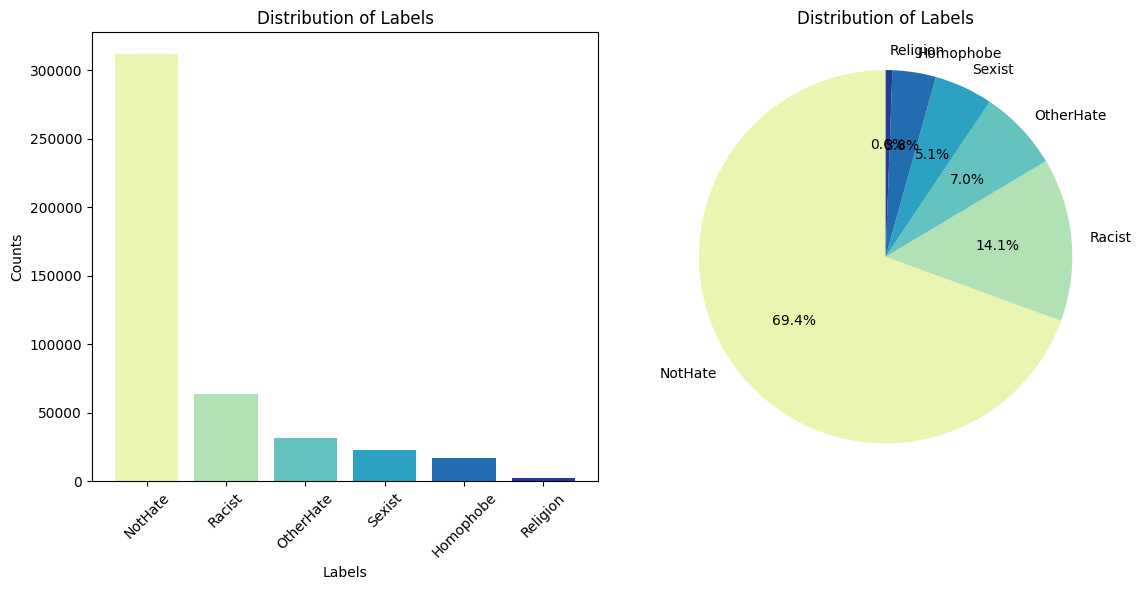

In [7]:
# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart
axes[0].bar(label_counts.keys(), label_counts.values(), color=sns.color_palette('YlGnBu'))
axes[0].set_xlabel("Labels")
axes[0].set_ylabel("Counts")
axes[0].set_title("Distribution of Labels")
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(
    label_counts.values(),
    labels=label_counts.keys(),
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('YlGnBu')
)
axes[1].set_title('Distribution of Labels')
axes[1].axis('equal')

# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
df_exploded['tweet_length'] = df_exploded['tweet_text'].apply(len)

df_exploded.head()

,tweet_text,labels,labels_str,tweet_length
0,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]",Religion,44
0,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]",Racist,44
0,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]",Homophobe,44
1,My horses are retarded https://t.co/HYhqc6d5WN,"[5, 5, 5]",OtherHate,46
1,My horses are retarded https://t.co/HYhqc6d5WN,"[5, 5, 5]",OtherHate,46


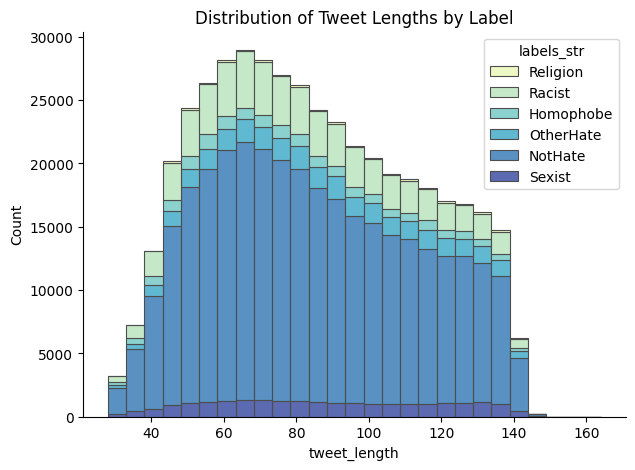

In [9]:
# Distribution of tweet lengths

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(
    data=df_exploded,
    x='tweet_length',
    hue='labels_str',
    binwidth=5,
    multiple="stack",
    palette="YlGnBu",
    edgecolor=".3",
    linewidth=0.8,
)

ax.set_title("Distribution of Tweet Lengths by Label")
plt.show()

# Data Manipulation

since the number of tweets with 'Religion' label is too small we can consider religion hate as 'OtherHate'

In [10]:
def modify_labels(row):
    labels = row['labels']
    labels_str = row['labels_str']
    modified_labels = [4 if x == 5 else x for x in labels] # Replace all occurrences of 5 with 4
    modified_labels_str = ['OtherHate' if x == 'Religion' else x for x in labels_str]
    return pd.Series({'labels': modified_labels, 'labels_str': modified_labels_str})

df[['labels', 'labels_str']] = df.apply(modify_labels, axis=1)
df.head()

,tweet_text,labels,labels_str
0,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]","[OtherHate, Racist, Homophobe]"
1,My horses are retarded https://t.co/HYhqc6d5WN,"[4, 4, 4]","[OtherHate, OtherHate, OtherHate]"
2,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,"[0, 0, 0]","[NotHate, NotHate, NotHate]"
3,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[1, 0, 0]","[Racist, NotHate, NotHate]"
4,“EVERYbody calling you Nigger now!” https://t....,"[1, 0, 1]","[Racist, NotHate, Racist]"




encode the labels into a binary list.

In [11]:
mlb = MultiLabelBinarizer()
df['encoded_labels'] = list(mlb.fit_transform(df['labels']))
df.head()

,tweet_text,labels,labels_str,encoded_labels
0,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]","[OtherHate, Racist, Homophobe]","[0, 1, 0, 1, 1]"
1,My horses are retarded https://t.co/HYhqc6d5WN,"[4, 4, 4]","[OtherHate, OtherHate, OtherHate]","[0, 0, 0, 0, 1]"
2,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,"[0, 0, 0]","[NotHate, NotHate, NotHate]","[1, 0, 0, 0, 0]"
3,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[1, 0, 0]","[Racist, NotHate, NotHate]","[1, 1, 0, 0, 0]"
4,“EVERYbody calling you Nigger now!” https://t....,"[1, 0, 1]","[Racist, NotHate, Racist]","[1, 1, 0, 0, 0]"


to address the data imbalance in 'NotHate' class, we drop the rows which only contain 'NotHate' labels

In [12]:
# Create a boolean mask for rows where 'labels' is [0, 0, 0]
mask = df['labels'].apply(lambda x: x != [0, 0, 0])

# Apply the mask to filter the DataFrame
filtered_df = df[mask]

filtered_df.head()

,tweet_text,labels,labels_str,encoded_labels
0,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]","[OtherHate, Racist, Homophobe]","[0, 1, 0, 1, 1]"
1,My horses are retarded https://t.co/HYhqc6d5WN,"[4, 4, 4]","[OtherHate, OtherHate, OtherHate]","[0, 0, 0, 0, 1]"
3,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[1, 0, 0]","[Racist, NotHate, NotHate]","[1, 1, 0, 0, 0]"
4,“EVERYbody calling you Nigger now!” https://t....,"[1, 0, 1]","[Racist, NotHate, Racist]","[1, 1, 0, 0, 0]"
6,@WhiteHouse @realDonaldTrump Fuck ice. White s...,"[4, 1, 1]","[OtherHate, Racist, Racist]","[0, 1, 0, 0, 1]"


since the majority of tweets have the length less than 140 charachters we can filter the tweets with longer length

In [13]:
# Filter the DataFrame to include only tweets with length <= 140
filtered_df['tweet_length'] = filtered_df['tweet_text'].apply(len)
filtered_df = filtered_df[filtered_df['tweet_length'] <= 140]
# filtered_df.head()

<ipython-input-13-7df04548c551>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tweet_length'] = filtered_df['tweet_text'].apply(len)


this is our final dataframe so let's take another look to labels distributions

{'NotHate': 83233, 'Racist': 49850, 'Sexist': 18875, 'Homophobe': 12153, 'OtherHate': 26648}


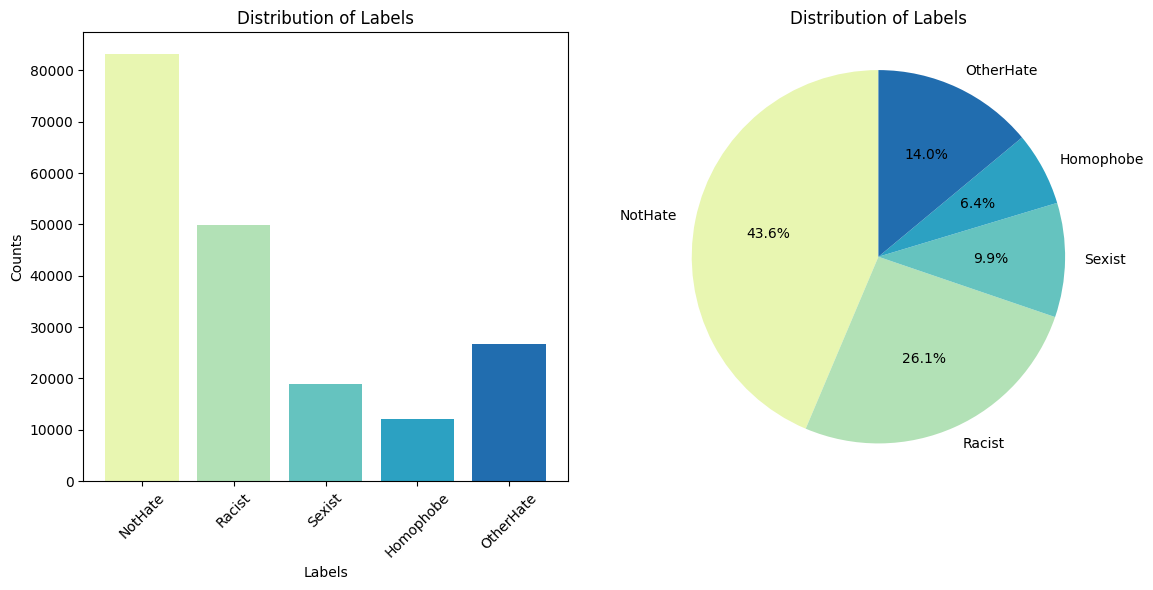

In [14]:
label_counts = sum(filtered_df['encoded_labels'])
map_labels = { 0: 'NotHate', 1: 'Racist', 2: 'Sexist', 3: 'Homophobe', 4: 'OtherHate'}
label_count_dict = {map_labels[i]: count for i, count in enumerate(label_counts)}
print(label_count_dict)

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart
axes[0].bar(label_count_dict.keys(), label_count_dict.values(), color=sns.color_palette('YlGnBu'))
axes[0].set_xlabel("Labels")
axes[0].set_ylabel("Counts")
axes[0].set_title("Distribution of Labels")
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(
    label_count_dict.values(),
    labels=label_count_dict.keys(),
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('YlGnBu')
)
axes[1].set_title('Distribution of Labels')
axes[1].axis('equal')

# Adjust layout
plt.tight_layout()
plt.show()

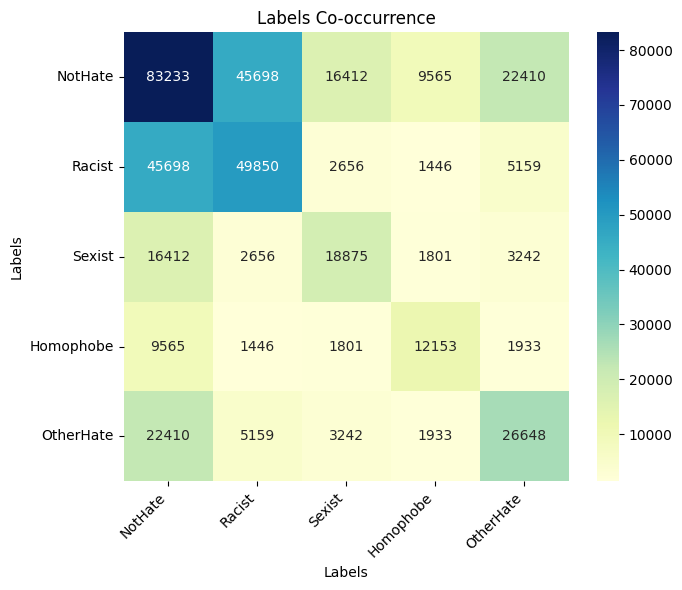

In [25]:

encoded_labels_array = np.array(filtered_df['encoded_labels'].tolist())

# Calculate the cross-tabulation (co-occurrence matrix)
cross_tab = np.dot(encoded_labels_array.T, encoded_labels_array)

# Visualize
plt.figure(figsize=(7, 6))
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=label_count_dict.keys(), yticklabels=label_count_dict.keys())
plt.title("Labels Co-occurrence")
plt.xlabel("Labels")
plt.ylabel("Labels")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Data Preprocessing

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to map POS tags to the format used by WordNetLemmatizer
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    # Normalize text
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'@\S+', '', text)  # Remove mentions
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = re.sub(r'http\S+', '', text)  # Remove URLs from the tweet
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters (there are emojis in some tweets)

    # Tokenize and lemmatize
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    return ' '.join(tokens)



In [ ]:
# Apply the clean_text function to the 'tweet' column
filtered_df['clean'] = filtered_df['tweet_text'].apply(clean_text)

filtered_df[['tweet_text', 'clean', 'labels_str']].head(10)

,tweet_text,clean,labels_str
0,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,nigga,"[OtherHate, Racist, Homophobe]"
1,My horses are retarded https://t.co/HYhqc6d5WN,horse retard,"[OtherHate, OtherHate, OtherHate]"
3,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,rt xxsugvngxx ran holy nigga today,"[Racist, NotHate, NotHate]"
4,“EVERYbody calling you Nigger now!” https://t....,everybody call nigger now,"[Racist, NotHate, Racist]"
6,@WhiteHouse @realDonaldTrump Fuck ice. White s...,fuck ice white supremacist trash racist garbage,"[OtherHate, Racist, Racist]"
8,#sissy faggot https://t.co/bm1nk8HcYO,sissy faggot,"[Homophobe, Homophobe, NotHate]"
9,@Gloriko_ Nigga what? https://t.co/nOwIJtgtU1,nigga,"[OtherHate, NotHate, Homophobe]"
13,Who dafuqq is this nigga https://t.co/D6YwVyGjNZ,dafuqq nigga,"[NotHate, Racist, Racist]"
14,bf: move your bighead 😅😂 gf: NIGGA WHAT?? THA...,bf move bighead gf nigga thats daddy left,"[Sexist, Sexist, Racist]"
15,@OriginalSlimC This fat nigga slander is getti...,fat nigga slander get outta hand,"[Homophobe, NotHate, NotHate]"


In [ ]:
# Instantiate the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2), min_df=5)

# Fit and transform the 'clean' column
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_df['clean']).toarray()

print(tfidf_matrix.shape)


(91802, 1000)


In [ ]:
X= tfidf_matrix
y= filtered_df['encoded_labels'].tolist()

In [ ]:
X = np.array([np.array(vec) for vec in X])
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Naive Bayes

In [ ]:
# Initialize Multinomial Naive Bayes and wrap it with OneVsRestClassifier
classifier = OneVsRestClassifier(MultinomialNB())
classifier.fit(X_train, y_train)

# Predict
y_pred_NB = classifier.predict(X_test)

# Evaluate
NB_classification_report = classification_report(y_test, y_pred_NB, zero_division=0)
print("Classification Report:\n", NB_classification_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      8295
           1       0.80      0.86      0.83      5012
           2       0.69      0.28      0.40      1809
           3       0.79      0.34      0.48      1223
           4       0.75      0.39      0.52      2675

   micro avg       0.84      0.77      0.80     19014
   macro avg       0.78      0.57      0.63     19014
weighted avg       0.83      0.77      0.77     19014
 samples avg       0.85      0.78      0.79     19014



### Per Label Accuracy:

This metric calculate the percentage of samples for which the predeicted labels matche the true labels for each label separately

In [ ]:
# Per Label Accuracy
label_accuracies_NB = []
for i in range(y_test.shape[1]):
    label_accuracy_NB = accuracy_score(y_test[:, i], y_pred_NB[:, i])
    label_accuracies_NB.append(label_accuracy_NB)

print("Per-label Accuracies:", label_accuracies_NB)


Per-label Accuracies: [0.9035947712418301, 0.8026143790849674, 0.8336601307189543, 0.8998910675381263, 0.7842047930283225]


### Subset Accuracy (Exact Match Accuracy):
This metric calculates the percentage of samples for which the predicted set of labels matches the true set of labels exactly.

In [ ]:
# Subset Accruracy
NB_accuracy = accuracy_score(y_test, y_pred_NB)
print(f"Subset Accuracy: {NB_accuracy:.4f}")


Subset Accuracy: 0.5052


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Initialize Logistic Regression and wrap it with OneVsRestClassifier
classifier = OneVsRestClassifier(LogisticRegression(max_iter= 100))
classifier.fit(X_train, y_train)

# Predict
y_pred_LR = classifier.predict(X_test)

# Evaluate
LR_classification_report = classification_report(y_test, y_pred_LR, zero_division=0)
print("Classification Report:\n", LR_classification_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      8295
           1       0.81      0.87      0.84      5012
           2       0.67      0.38      0.48      1809
           3       0.81      0.61      0.69      1223
           4       0.75      0.45      0.57      2675

   micro avg       0.85      0.81      0.82     19014
   macro avg       0.79      0.66      0.71     19014
weighted avg       0.83      0.81      0.81     19014
 samples avg       0.85      0.82      0.82     19014



In [ ]:
# Per Label Accuracy
label_accuracies_LR = []
for i in range(y_test.shape[1]):
    label_accuracy_LR = accuracy_score(y_test[:, i], y_pred_LR[:, i])
    label_accuracies_LR.append(label_accuracy_LR)

print("Per-label Accuracies:", label_accuracies_LR)


Per-label Accuracies: [0.9033769063180828, 0.8221132897603486, 0.8407407407407408, 0.9282135076252723, 0.7976034858387799]


In [ ]:
# Subset Accruracy
LR_accuracy = accuracy_score(y_test, y_pred_LR)
print(f"Subset Accuracy: {LR_accuracy:.4f}")


Subset Accuracy: 0.5556


#BERT

In [ ]:
!pip install bert

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# token distription without truncation or padding
filtered_df['clean'].apply(len).describe()


,clean
count,91802.000000
mean,34.750300
std,19.076125
min,3.000000
25%,19.000000
50%,32.000000
75%,48.000000
max,113.000000


In [ ]:
filtered_df['bert_tokens'] = filtered_df['tweet_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True,
                                                                                   max_length=64,
                                                                                   padding='max_length',
                                                                                   truncation=True))
filtered_df[['clean','bert_tokens','encoded_labels']].head(5)

,clean,bert_tokens,encoded_labels
0,nigga,"[101, 1030, 10424, 20573, 5280, 21246, 14643, ...","[0, 1, 0, 1, 1]"
1,horse retard,"[101, 2026, 5194, 2024, 2128, 7559, 5732, 1677...","[0, 0, 0, 0, 1]"
3,rt xxsugvngxx ran holy nigga today,"[101, 19387, 22038, 6342, 2290, 16022, 2290, 2...","[1, 1, 0, 0, 0]"
4,everybody call nigger now,"[101, 1523, 7955, 4214, 2017, 9152, 13327, 208...","[1, 1, 0, 0, 0]"
6,fuck ice white supremacist trash racist garbage,"[101, 1030, 2317, 4580, 1030, 2613, 5280, 1905...","[0, 1, 0, 0, 1]"


In [ ]:
X = np.array(filtered_df['bert_tokens'].tolist())
y = np.array(filtered_df['encoded_labels'].tolist())

In [ ]:
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle= False)
val_dataloader = DataLoader(val_dataset, batch_size= batch_size, shuffle= False)
test_dataloader = DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

In [ ]:
from transformers import BertForSequenceClassification

bert_model= BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:

optimizer = AdamW(bert_model.parameters(), lr=1e-5, weight_decay=0.01)
scaler = GradScaler()  # Initialize GradScaler for mixed-precision training
loss_fct = torch.nn.BCEWithLogitsLoss()

num_epoch = 5

total_train_loss = 0
total_val_loss = 0
train_loss = []
val_loss = []

for epoch in range(num_epoch):
    bert_model.train()
    total_train_loss = 0

    for batch in train_dataloader:
        input_ids, labels = batch
        input_ids, labels = input_ids.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass with mixed precision
        with autocast():
            outputs = bert_model(input_ids)
            loss = loss_fct(outputs.logits, labels.type(torch.float))

        # Scales loss to avoid underflow during backward pass
        scaler.scale(loss).backward()

        # Unscales gradients and updates the optimizer
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss.append(avg_train_loss)


    # Validation loop
    bert_model.eval()
    total_val_loss = 0  # Reset val loss for each epoch
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, labels = batch
            input_ids, labels = input_ids.to(device), labels.to(device)

            with autocast():  # Also use mixed precision in validation
                outputs = bert_model(input_ids)
                loss = loss_fct(outputs.logits, labels.type(torch.float))
                total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_loss.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{num_epoch} -AVG_Train_Loss: {avg_train_loss:.4F} - AVG_Val_Loss: {avg_val_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-23-93451bf81da1>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Initialize GradScaler for mixed-precision training
<ipython-input-23-93451bf81da1>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
<ipython-input-23-93451bf81da1>:48: FutureWarning: `torch.cuda.amp.autoc

Epoch 1/5 -AVG_Train_Loss: 0.3786 - AVG_Val_Loss: 0.3548
Epoch 2/5 -AVG_Train_Loss: 0.3495 - AVG_Val_Loss: 0.3541
Epoch 3/5 -AVG_Train_Loss: 0.3436 - AVG_Val_Loss: 0.3565
Epoch 4/5 -AVG_Train_Loss: 0.3351 - AVG_Val_Loss: 0.3613
Epoch 5/5 -AVG_Train_Loss: 0.3234 - AVG_Val_Loss: 0.3681


In [ ]:
def compute_subset_accuracy(predictions, labels):
    """
    Subset accuracy requires an exact match for all labels in a sample.
    """
    # Apply sigmoid to get probabilities for each label
    probabilities = torch.sigmoid(predictions)

    # Threshold the probabilities to get predicted labels (0 or 1)
    predicted_labels = (probabilities > 0.5).int()

    # Check if all labels match exactly for each sample
    exact_matches = torch.all(predicted_labels == labels, dim=1).sum().item()

    # Calculate subset accuracy
    total_samples = labels.size(0)
    subset_accuracy = exact_matches / total_samples
    return subset_accuracy


In [ ]:
def compute_per_label_accuracy(predictions, labels):

    # Apply sigmoid to get probabilities for each label
    probabilities = torch.sigmoid(predictions)

    # Threshold the probabilities to get predicted labels (0 or 1)
    predicted_labels = (probabilities > 0.5).int()

    # Compute per-label accuracy
    correct_per_label = torch.eq(predicted_labels, labels).sum(dim=0)
    total_per_label = labels.sum(dim=0) + (labels.size(0) - labels.sum(dim=0))  # Total labels (1s and 0s)
    per_label_accuracy = (correct_per_label / total_per_label).cpu().numpy()
    return per_label_accuracy


In [ ]:

def generate_classification_report(predictions, labels):

    # Apply sigmoid to get probabilities for each label
    probabilities = torch.sigmoid(predictions)

    # Threshold the probabilities to get predicted labels (0 or 1)
    predicted_labels = (probabilities > 0.5).int().cpu().numpy()
    true_labels = labels.cpu().numpy()

    # Generate and return classification report
    return classification_report(true_labels, predicted_labels, zero_division=0)


In [ ]:

bert_model.eval()
all_predictions = []
all_labels = []

subset_accuracy_total = 0
num_batches = 0

with torch.no_grad():
    for batch in test_dataloader:
        inputs_text, labels = batch
        inputs_text, labels = inputs_text.to(device), labels.to(device)

        # Forward pass
        outputs = bert_model(inputs_text)

        # Append predictions and labels for classification report and metrics
        all_predictions.append(outputs.logits)
        all_labels.append(labels)

        # Compute subset accuracy for the current batch
        subset_accuracy_total += compute_subset_accuracy(outputs.logits, labels)
        num_batches += 1

# Concatenate all predictions and labels for global metrics
all_predictions = torch.cat(all_predictions, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Compute average subset accuracy
avg_subset_accuracy = subset_accuracy_total / num_batches

# Compute per-label accuracy
per_label_accuracy = compute_per_label_accuracy(all_predictions, all_labels)

# Generate classification report
class_report = generate_classification_report(all_predictions, all_labels)

print(f"Subset Accuracy: {avg_subset_accuracy:.4f}")
print(f"Per-Label Accuracy: {per_label_accuracy}")
print("\nClassification Report:")
print(class_report)


Subset Accuracy: 0.5651
Per-Label Accuracy: [0.9037037  0.81165576 0.8361656  0.93366015 0.8       ]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      8295
           1       0.83      0.83      0.83      5012
           2       0.59      0.57      0.58      1809
           3       0.79      0.68      0.73      1223
           4       0.74      0.49      0.59      2675

   micro avg       0.83      0.82      0.83     19014
   macro avg       0.77      0.71      0.73     19014
weighted avg       0.82      0.82      0.82     19014
 samples avg       0.84      0.83      0.83     19014



In [ ]:
label_accuracies_bert = per_label_accuracy.tolist()

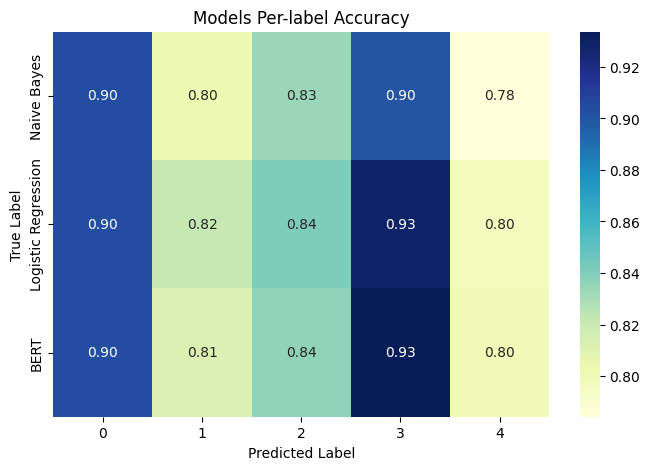

In [ ]:
matrix = [label_accuracies_NB, label_accuracies_LR, label_accuracies_bert]
# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=['0','1','2','3','4'], yticklabels=['Naive Bayes', 'Logistic Regression', 'BERT'])

plt.title("Models Per-label Accuracy")
plt.xlabel("Accuracy")
plt.show()

In [ ]:
# Create a figure
plt.figure(figsize=(6, 0.6))
plt.text(0.01, 1.0, class_report, {'fontsize': 10}, fontproperties='monospace')
plt.axis('off')
plt.tight_layout()

# Save the figure
plt.savefig("Bert_classification_report.png", dpi=300, bbox_inches='tight')
plt.close()

<ipython-input-29-f44003e93d32>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
